# Generative Fill example on Amazon SageMaker using DLC container.

In this notebook, we explore how to build generative fill application and host Stable Diffusion/ ControlNet / segment anything models on SageMaker asynchronous endpoint using BYOC (Bring-your-own-container).

In this notebook, under the hood we use stable-diffusion-webui and extensions to generate image. 

Note - Amazon Web Services has no control or authority over the third-party generative AI service referenced in this Workshop, and does not make any representations or warranties that the third-party generative AI service is secure, virus-free, operational, or compatible with your production environment and standards. You are responsible for making your own independent assessment of the content provided in this Workshop, and take measures to ensure that you comply with your own specific quality control practices and standards, and the local rules, laws, regulations, licenses and terms of use that apply to you, your content, and the third-party generative AI service referenced in this Workshop. The content of this Workshop: (a) is for informational purposes only, (b) represents current Amazon Web Services product offerings and practices, which are subject to change without notice, and (c) does not create any commitments or assurances from Beijing Sinnet Technology Co., Ltd. (“Sinnet”), Ningxia Western Cloud Data Technology Co., Ltd. (“NWCD”), Amazon Connect Technology Services (Beijing) Co., Ltd. (“Amazon”), or their respective affiliates, suppliers or licensors.  Amazon Web Services’ content, products or services are provided “as is” without warranties, representations, or conditions of any kind, whether express or implied.  The responsibilities and liabilities of Sinnet, NWCD or Amazon to their respective customers are controlled by the applicable customer agreements. 

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

---

## Build Docker image and push to ECR.

Initialize the variables for SageMaker default bucket, role, and AWS account ID, and current AWS region.

In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name

Execute the script to build Docker images for SageMaker endpoint.

In [2]:
%%sh -s "$region_name"

pip install sagemaker-studio-image-build

# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.

region=$1

inference_image=all-in-one-ai-stable-diffusion-webui-inference-api:latest

sm-docker build . -f Dockerfile.inference --build-arg REGION=${region} --repository ${inference_image}


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


.................[Container] 2023/11/22 04:01:22.941566 Waiting for agent ping

[Container] 2023/11/22 04:01:24.942804 Waiting for DOWNLOAD_SOURCE
[Container] 2023/11/22 04:01:29.774590 Phase is DOWNLOAD_SOURCE
[Container] 2023/11/22 04:01:29.776816 CODEBUILD_SRC_DIR=/codebuild/output/src1999996982/src
[Container] 2023/11/22 04:01:29.777289 YAML location is /codebuild/output/src1999996982/src/buildspec.yml
[Container] 2023/11/22 04:01:29.779653 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2023/11/22 04:01:29.779806 Processing environment variables
[Container] 2023/11/22 04:01:29.858634 No runtime version selected in buildspec.
[Container] 2023/11/22 04:01:29.897050 Moving to directory /codebuild/output/src1999996982/src
[Container] 2023/11/22 04:01:29.898447 Unable to initialize cache download: no paths specified to be cached
[Container] 2023/11/22 04:01:29.898576 Configuring ssm agent with target id: codebuild:ead18f51-f53e-46d9-aa6b-1d0e64d59d1d
[Container]

Upload the dummy file to S3 to meet the requirement of SageMaker Endpoint for model data.

In [3]:
model_data = "s3://{0}/stable-diffusion-webui/data/model.tar.gz".format(bucket)
!touch dummy
!tar czvf model.tar.gz dummy
!rm dummy
!aws s3 cp model.tar.gz $model_data

dummy
upload: ./model.tar.gz to s3://sagemaker-us-east-1-xxxxxxxxxxxx/stable-diffusion-webui/data/model.tar.gz


## Deploy to SageMaker Asychronous Endpoint

Initialized the variables for URI of Docker Inference Endpoint.

In [4]:
model_name = None
image_uri = "{0}.dkr.ecr.{1}.amazonaws.com/all-in-one-ai-stable-diffusion-webui-inference-api:latest".format(
    account_id, region_name
)

Define the models configuration in order to download those models from one of source - HTTP, S3 and HuggingFace. Note: Here as an example the Lora model - 2bNierAutomataLora_v2b.safetensors and ControlNet model - control_sd15_canny.pth are going to be downloaded from Civitai and Huggingface directly once the SageMaker endpoint is created.

In [5]:
import json

huggingface_models = [
    {
        "repo_id": "lllyasviel/ControlNet-v1-1",
        "filename": "control_v11p_sd15_inpaint.pth",
        "name": "ControlNet",
    }
]

model_environment = {
    "huggingface_models": json.dumps(huggingface_models),
    "embeddings_s3uri": f"s3://{bucket}/stable-diffusion-webui/embeddings/",
    "hypernetwork_s3uri": f"s3://{bucket}/stable-diffusion-webui/hypernetwork/",
}

Define the model, instance type and instance initial count for SageMaker endpoint.

In [6]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

model = Model(
    name=model_name,
    model_data=model_data,
    role=role,
    image_uri=image_uri,
    env=model_environment,
    predictor_cls=Predictor,
)

instance_type = "ml.g5.2xlarge"
instance_count = 1

Define the SageMaker Asychronous Inference config

In [7]:
from sagemaker.async_inference import AsyncInferenceConfig

async_config = AsyncInferenceConfig(
    output_path="s3://{0}/{1}/asyncinvoke/out/".format(bucket, "stable-diffusion-webui")
)

Here we use asynchronous inference since asynchronous inference is more suitable for workloads with large payload sizes and long inference processing times. 

In [8]:
predictor = model.deploy(
    instance_type=instance_type,
    initial_instance_count=instance_count,
    volume_size_in_gb=225,
    container_startup_health_check_timeout=1800,
    async_inference_config=async_config,
)

-----------------!

## Generate initial image using text prompt

In [9]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    "task": "text-to-image",
    "txt2img_payload": {
        "prompt": "((Best quality)), ((masterpiece)), ((realistic)), (detailed), cute panda ((standing in a asian garden with cherry trees)) ((masterpiece)), absurdres, HDR",
        "negative_prompt": "(bad quality)",
        "seed": 2816240246,
        "sampler_name": "Euler a",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 7,
        "width": 512,
        "height": 768,
        "alwayson_scripts": {},
    },
}

prediction = predictor.predict_async(inputs)

Helper function for S3.

In [10]:
import json
import io

s3_resource = boto3.resource("s3")


def get_bucket_and_key(s3uri):
    pos = s3uri.find("/", 5)
    bucket = s3uri[5:pos]
    key = s3uri[pos + 1 :]
    return bucket, key

Wait until the asychronous inference is done in case we use asynchronous inference for image generation. 

In [11]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f1e5c64d7e0>
Response output path: s3://sagemaker-us-east-1-xxxxxxxxxxxx/stable-diffusion-webui/asyncinvoke/out/a01bc60c-8d42-42f8-9d88-7797910410b3.out
Start Polling to get response:
Time taken: 1.1179356575012207s


Process the generated images from asynchronous inference result.

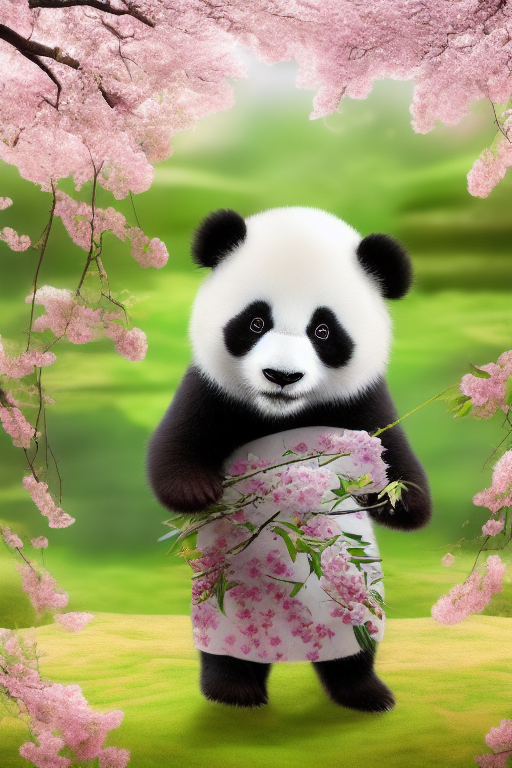

In [12]:
import traceback
from PIL import Image
import uuid
from io import BytesIO
from datetime import datetime
import base64

try:
    output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    output_obj = s3_resource.Object(output_bucket, output_key)
    body = output_obj.get()["Body"].read().decode("utf-8")
    image_object = json.loads(body)["images"][0]
    image = Image.open(BytesIO(base64.b64decode(image_object)))
    image.show()
    initial_image_filename = datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.png")
    image.save(initial_image_filename)
except Exception as e:
    traceback.print_exc()
    print(e)

## Expand initial image using text prompt and ControlNet models

ControlNet is a neural network structure to control diffusion models by adding extra conditions.

In [13]:
from PIL import Image
import base64
import io

def encode_image_to_base64(image):
    with io.BytesIO() as output_bytes:
        if isinstance(image, dict):
            image = image['image']
        format = "PNG" if image.mode == 'RGBA' else "JPEG"
        image.save(output_bytes, format=format)
        bytes_data = output_bytes.getvalue()

    encoded_string = base64.b64encode(bytes_data)

    base64_str = str(encoded_string, "utf-8")
    mimetype = "image/jpeg" if format == 'JPEG' else 'image/png'
    image_encoded_in_base64 = (
        "data:" + (mimetype if mimetype is not None else "") + ";base64," + base64_str
    )
    return image_encoded_in_base64

def decode_base64_to_image(encoding):
    if encoding.startswith("data:image/"):
        encoding = encoding.split(";")[1].split(",")[1]
    try:
        image = Image.open(io.BytesIO(base64.b64decode(encoding)))
        return image
    except Exception as e:
        print(e)

Define the payload for SageMaker inference.

In [14]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    "task": "image-to-image",
    "img2img_payload": {
        "prompt": "((Best quality)), ((masterpiece)), ((realistic)), (detailed), cute panda ((standing in a asian garden with cherry trees)) ((masterpiece)), absurdres, HDR",
        "negative_prompt": "(bad quality)",
        "init_images": [encode_image_to_base64(image)],
        "mask": None,
        "steps": 20,
        "sampler_name": "DPM++ 2S a Karras",
        "batch_size": 1,
        "n_iter": 1,
        "cfg_scale": 7,
        "denoising_strength": 0.8,
        "seed": 2866147124,
        "height": 768,
        "width": 1280,
        "resize_mode": 0,
        "include_init_images": False,
        "alwayson_scripts": {
            "controlnet": {
                "args": [
                    {
                        "enabled": True,
                        "module": "inpaint_only+lama",
                        "model": "control_v11p_sd15_inpaint [ebff9138]",
                        "image": encode_image_to_base64(image),
                        "resize_mode": "Resize and Fill",
                        "low_vram": False,
                        "weight": 1,
                        "guidance_start": 0,
                        "guidance_end": 1,
                        "pixel_perfect": False,
                        "control_mode": "ControlNet is more important",
                    }
                ]
            }
        },
    },
}

prediction = predictor.predict_async(inputs)

Wait until the asynchronous inference is done in case we use asynchronous inference for image generation. 

In [15]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f1e5c6d3820>
Response output path: s3://sagemaker-us-east-1-xxxxxxxxxxxx/stable-diffusion-webui/asyncinvoke/out/afc0e38a-f6bf-4e07-b66d-2a2aa377b4e8.out
Start Polling to get response:
Time taken: 31.117440938949585s


Process the generated images from asynchronous inference result.

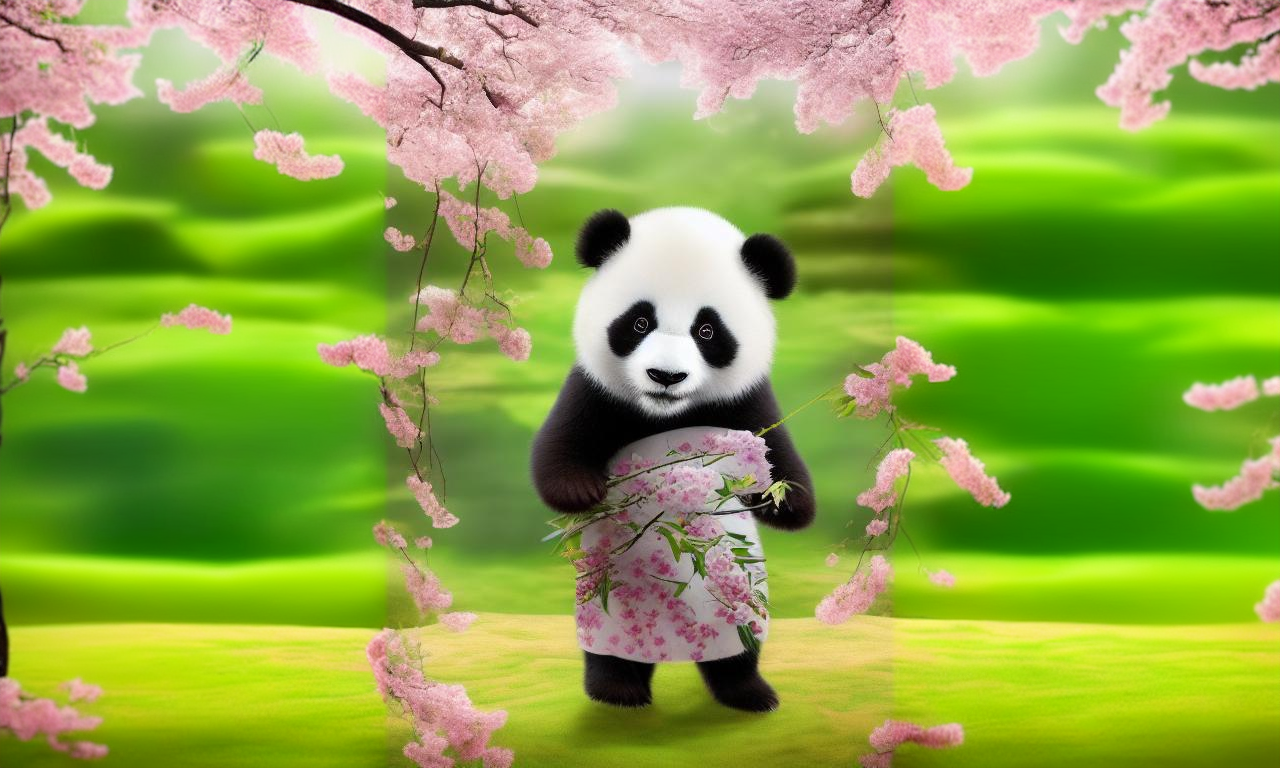

In [16]:
import traceback
from PIL import Image
import uuid
from io import BytesIO
from datetime import datetime
import base64

try:
    output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    output_obj = s3_resource.Object(output_bucket, output_key)
    body = output_obj.get()["Body"].read().decode("utf-8")
    image_object = json.loads(body)["images"][0]
    image2 = Image.open(BytesIO(base64.b64decode(image_object)))
    image2.show()
    image2.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.png"))
except Exception as e:
    traceback.print_exc()
    print(e)

## Run generative fill application built with Gradio framework

In [17]:
endpoint_name = predictor.endpoint_name

In [18]:
!git clone https://github.com/xieyongliang/generative-fill-webui.git

Cloning into 'generative-fill-webui'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 57 (delta 28), reused 34 (delta 9), pack-reused 0
Unpacking objects: 100% (57/57), 108.55 KiB | 65.00 KiB/s, done.


In [19]:
!cd ./generative-fill-webui && export sagemaker_endpoint=$endpoint_name && pip install -r requirements.txt && python ui.py


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
The execution result is not ready
The execution result is fetched
{'status_code': 200, 'text': '[{"title":"v1-5-pruned-emaonly.safetensors [6ce0161689]","model_name":"v1-5-pruned-emaonly","hash":"6ce0161689","sha256":"6ce0161689b3853acaa03779ec93eafe75a02f4ced659bee03f50797806fa2fa","filename":"/tmp/models/Stable-diffusion/v1-5-pruned-emaonly.safetensors","config":null}]'}
The execution result is not ready
The execution result is fetched
{'status_code': 200, 'text': '{"model_list":["control_v11p_sd15_inpaint [ebff9138]"]}'}
['None', 'control_v11p_sd15_inpaint [ebff9138]']
/root/amazon-sagemaker-examples/inference/generativeai/llm-workshop/lab12-hosting-controlnet-models-on-sagemaker/generative-fill-webui/utils.py:347: GradioUnusedKwargWarning: You have unused kwarg parameters in Image, please remove them: {'brush_color': '#ffffff'}
  res = original_IOComponent_init(self, *ar

## [Optional] Create auto-scaling group for SageMaker endpoint in case you want to scale it based on specific metrics automatically.

In [ ]:
def create_autoscaling_group_for_sagemaker_endpoint(
    endpoint_name, min_capcity=1, max_capcity=2, target_value=5
):
    # application-autoscaling client
    asg_client = boto3.client("application-autoscaling")

    # This is the format in which application autoscaling references the endpoint
    resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

    # Configure Autoscaling on asynchronous endpoint down to zero instances
    response = asg_client.register_scalable_target(
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        MinCapacity=min_capcity,
        MaxCapacity=max_capcity,
    )

    response = asg_client.put_scaling_policy(
        PolicyName=f"Request-ScalingPolicy-{endpoint_name}",
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        PolicyType="TargetTrackingScaling",
        TargetTrackingScalingPolicyConfiguration={
            "TargetValue": target_value,
            "CustomizedMetricSpecification": {
                "MetricName": "ApproximateBacklogSizePerInstance",
                "Namespace": "AWS/SageMaker",
                "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
                "Statistic": "Average",
            },
            "ScaleInCooldown": 600,  # duration until scale in begins (down to zero)
            "ScaleOutCooldown": 300,  # duration between scale out attempts
        },
    )


create_autoscaling_group_for_sagemaker_endpoint(predictor.endpoint_name)

## Resource cleanup.

In [ ]:
predictor.delete_endpoint()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.


![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/inference|generativeai|llm-workshop|lab12-hosting-controlnet-models-on-sagemaker|stable-diffusion-webui-async-inference.ipynb)
